In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.cluster.hierarchy as sch

def view_correlation(df, save=False):
    columns_to_exclude = ["image ID", "method", "attack", "true class", "predicted class", "original score", "adversarial score", "number of regions original",
                          "number of regions adversarial"]
    df_numeric = df.drop(columns=columns_to_exclude, errors='ignore').select_dtypes(include=np.number)
    
    if df_numeric.empty or df_numeric.shape[1] < 2:
        print("Not enough numeric columns found for correlation analysis after exclusions.")
        return

    correlation_matrix = df_numeric.corr(method="pearson")

        # Compute linkage from distance = 1 - abs(corr)
    pairwise_distances = 1 - correlation_matrix.abs()
    linkage = sch.linkage(pairwise_distances, method="average")

    # Get order of leaves (metric indices)
    dendro = sch.dendrogram(linkage, no_plot=True)
    ordered_cols = [correlation_matrix.columns[i] for i in dendro["leaves"]]

    # Reorder correlation matrix
    correlation_matrix = correlation_matrix.loc[ordered_cols, ordered_cols]

    plt.figure(figsize=(10, 8))
    
    # Use seaborn heatmap which handles labels better
    ax = sns.heatmap(correlation_matrix, 
                     annot=True, 
                     fmt='.2f', 
                     cmap='coolwarm', 
                     center=0,
                     square=True,
                     cbar_kws={'shrink': 0.8})
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.yticks(rotation=0, fontsize=11)
    
    plt.title("Correlation matrix of saliency map metrics", pad=10)
    plt.tight_layout()
    if save:
        plt.savefig("latex/img/results/targeted_correlation_matrix.svg", format='svg')
    plt.show()
    upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.8)]
    print("Highly correlated metrics:", to_drop)
    reduced_df = df_numeric.drop(columns=to_drop, errors='ignore')
    if reduced_df.empty or reduced_df.shape[1] < 2:
        print("No columns remaining or not enough columns after dropping highly correlated ones for reduced matrix.")
        return
        
    corr_reduced = reduced_df.corr(method="pearson")

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        corr_reduced,
        annot=True,
        cmap="coolwarm",
        vmin=-1,
        vmax=1,
        fmt=".2f",
        linewidths=0.5,
        cbar_kws={"label": "Pearson r"},
    )
    plt.title("Korrelationsmatrix nach Entfernen hoch korrelierter Metriken")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [2]:
results_df = pd.read_csv("results/big_dataset/targeted/cam_comparison_metrics_combined.csv")

In [3]:
metric_cols = [
    'mean pixel difference', 'percentage of different pixels', 'number of regions difference', 'cosine similarity', 'activation ratio', 'JS divergence',
    'important activation ratio', 'intersection over union', 'SSIM', 'Spearman\'s rank coefficient'
]

In [4]:
## check correlation of Linf Repeated Additive Uniform Noise attack iamges mean difference and metrics
linf_df = results_df[results_df["attack"] == "Linf Repeated Additive Uniform Noise"]
linf_df[metric_cols].corr(method="pearson")

,mean pixel difference,percentage of different pixels,number of regions difference,cosine similarity,activation ratio,JS divergence,important activation ratio,intersection over union,SSIM,Spearman's rank coefficient
mean pixel difference,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
percentage of different pixels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
number of regions difference,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cosine similarity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
activation ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
JS divergence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
important activation ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
intersection over union,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SSIM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Spearman's rank coefficient,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
## for all atacks in attack column, check correlation of images mean difference and metrics, print if correlation between image mean difference and any metric (except itself) is above 0.8
for attack in results_df["attack"].unique():
    attack_df = results_df[results_df["attack"] == attack]
    corr = attack_df[metric_cols + ["images mean difference"]].corr(method="pearson")

    # Exclude the self-correlation entry
    corr_vals = corr["images mean difference"].drop("images mean difference")
    high_corr = corr_vals[abs(corr_vals) > 0.8]
    if not high_corr.empty:
        print(f"High correlation found for {attack}:")
        print(high_corr)

In [6]:
## for all attacks, check if the correlation between metrics is similar for all attacks (deviation of less than 0.2)
corr_matrix = results_df[metric_cols].corr(method="pearson")
deviation_threshold = 0.2

for attack in results_df["attack"].unique():
    attack_df = results_df[results_df["attack"] == attack]
    corr = attack_df[metric_cols].corr(method="pearson")

    # Check if the absolute difference between the correlation matrices is less than the threshold

    # Compute absolute difference matrix
    diff = abs(corr_matrix - corr)

    # Create a boolean mask of significant deviations
    deviation_mask = diff >= deviation_threshold

    # Optional: print the locations and values of deviations
    if deviation_mask.any().any():
        print(f"Correlation for {attack} deviates significantly at the following entries:")
        print(diff[deviation_mask])

Correlation for Linf Proj. Gradient Descent (PGD) deviates significantly at the following entries:
                                mean pixel difference  \
mean pixel difference                             NaN   
percentage of different pixels                    NaN   
number of regions difference                      NaN   
cosine similarity                                 NaN   
activation ratio                                  NaN   
JS divergence                                     NaN   
important activation ratio                        NaN   
intersection over union                           NaN   
SSIM                                              NaN   
Spearman's rank coefficient                       NaN   

                                percentage of different pixels  \
mean pixel difference                                      NaN   
percentage of different pixels                             NaN   
number of regions difference                               NaN   
cosine si

In [7]:
## for all methods in method column, check if the correlation between metrics is similar for all methods (deviation of less than 0.2)
corr_matrix = results_df[metric_cols].corr(method="pearson")
deviation_threshold = 0.2

for method in results_df["method"].unique():
    method_df = results_df[results_df["method"] == method]
    corr = method_df[metric_cols].corr(method="pearson")

    # Check if the absolute difference between the correlation matrices is less than the threshold

    # Compute absolute difference matrix
    diff = abs(corr_matrix - corr)

    # Create a boolean mask of significant deviations
    deviation_mask = diff >= deviation_threshold
    deviations = diff[deviation_mask]

    # Optional: print the locations and values of deviations
    if deviation_mask.any().any():
        print(f"Correlation for {method} deviates significantly at the following entries:")
        for (row, col), value in deviations.stack().items():
            val1 = corr_matrix.loc[row, col]
            val2 = corr.loc[row, col]
            print(f"Deviation at ({row}, {col}): {val1:.3f} vs {val2:.3f} → Δ = {abs(val1 - val2):.3f}")

Correlation for GradCAM deviates significantly at the following entries:
Deviation at (mean pixel difference, activation ratio): 0.260 vs -0.215 → Δ = 0.476
Deviation at (mean pixel difference, important activation ratio): 0.498 vs -0.132 → Δ = 0.630
Deviation at (percentage of different pixels, activation ratio): 0.162 vs -0.199 → Δ = 0.361
Deviation at (percentage of different pixels, important activation ratio): 0.293 vs -0.103 → Δ = 0.396
Deviation at (number of regions difference, important activation ratio): 0.095 vs 0.327 → Δ = 0.232
Deviation at (activation ratio, mean pixel difference): 0.260 vs -0.215 → Δ = 0.476
Deviation at (activation ratio, percentage of different pixels): 0.162 vs -0.199 → Δ = 0.361
Deviation at (activation ratio, important activation ratio): 0.387 vs 0.103 → Δ = 0.285
Deviation at (activation ratio, SSIM): 0.049 vs 0.401 → Δ = 0.351
Deviation at (important activation ratio, mean pixel difference): 0.498 vs -0.132 → Δ = 0.630
Deviation at (important acti

In [8]:
# for all combinations of attack and method, check if the correlation between metrics is similar for all combinations (deviation of less than 0.2)
corr_matrix = results_df[metric_cols].corr(method="pearson")
deviation_threshold = 0.4

for attack in results_df["attack"].unique():
    for method in results_df["method"].unique():
        subset_df = results_df[(results_df["attack"] == attack) & (results_df["method"] == method)]
        if subset_df.empty:
            continue
        corr = subset_df[metric_cols].corr(method="pearson")

        # Check if the absolute difference between the correlation matrices is less than the threshold

        # Compute absolute difference matrix
        diff = abs(corr_matrix - corr)

        # Create a boolean mask of significant deviations
        deviation_mask = diff >= deviation_threshold
        deviations = diff[deviation_mask]

        # Print only the deviating entries with labels and formatted values
        
        # Optional: print the locations and values of deviations
        if deviation_mask.any().any():
            print(f"Correlation for {attack} with method {method} deviates significantly at the following entries:")
            for (row, col), value in deviations.stack().items():
                val1 = corr_matrix.loc[row, col]
                val2 = corr.loc[row, col]
                print(f"Deviation at ({row}, {col}): {val1:.3f} vs {val2:.3f} → Δ = {abs(val1 - val2):.3f}")

Correlation for L2 Proj. Gradient Descent (PGD) with method GradCAM deviates significantly at the following entries:
Deviation at (mean pixel difference, activation ratio): 0.260 vs -0.290 → Δ = 0.551
Deviation at (mean pixel difference, important activation ratio): 0.498 vs -0.157 → Δ = 0.654
Deviation at (percentage of different pixels, activation ratio): 0.162 vs -0.280 → Δ = 0.443
Deviation at (percentage of different pixels, important activation ratio): 0.293 vs -0.123 → Δ = 0.415
Deviation at (activation ratio, mean pixel difference): 0.260 vs -0.290 → Δ = 0.551
Deviation at (activation ratio, percentage of different pixels): 0.162 vs -0.280 → Δ = 0.443
Deviation at (important activation ratio, mean pixel difference): 0.498 vs -0.157 → Δ = 0.654
Deviation at (important activation ratio, percentage of different pixels): 0.293 vs -0.123 → Δ = 0.415
Correlation for L2 Proj. Gradient Descent (PGD) with method GradCAM++ deviates significantly at the following entries:
Deviation at (me

/var/folders/1w/ytjjn1392fd518g9vmt57xl80000gn/T/ipykernel_6387/2781750482.py:21: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = sch.linkage(pairwise_distances, method="average")


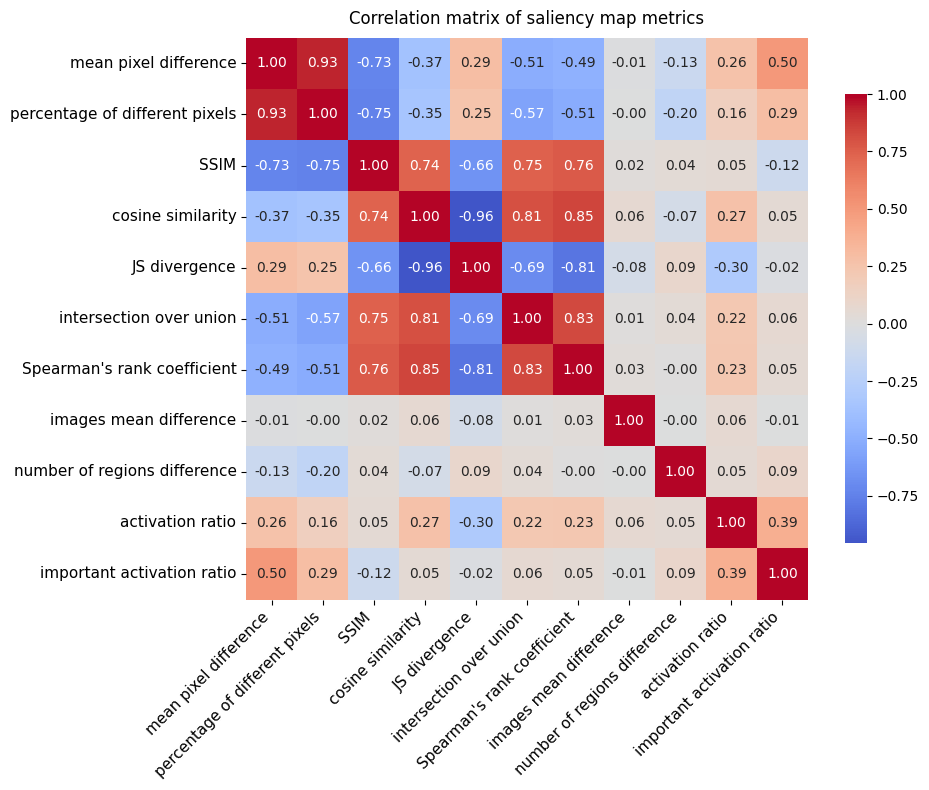

Highly correlated metrics: ['percentage of different pixels', 'JS divergence', 'intersection over union', "Spearman's rank coefficient"]


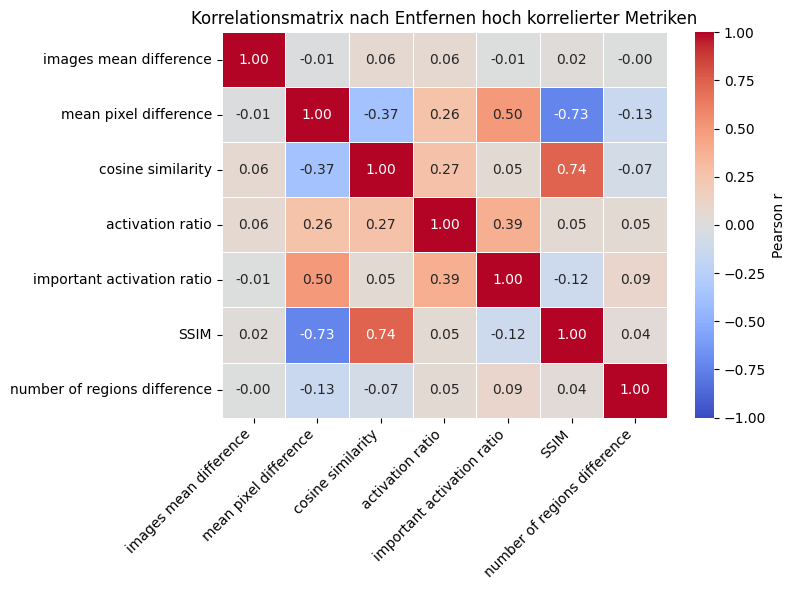

In [9]:
view_correlation(results_df, save=True)

In [10]:
#### doing pca to reduce dimensions

results_df.columns

Index(['image ID', 'method', 'attack', 'true class', 'predicted class',
       'images mean difference', 'original score', 'adversarial score',
       'mean pixel difference', 'percentage of different pixels',
       'number of regions original', 'number of regions adversarial',
       'cosine similarity', 'activation ratio', 'JS divergence',
       'important activation ratio', 'intersection over union', 'SSIM',
       'Spearman's rank coefficient', 'number of regions difference'],
      dtype='object')

In [11]:
# List of metric columns you want to analyze
metric_cols = [
    'mean pixel difference', 'percentage of different pixels', 'number of regions difference', 'cosine similarity', 'activation ratio', 'JS divergence',
    'important activation ratio', 'intersection over union', 'SSIM', 'Spearman\'s rank coefficient'
]

In [16]:
results_df[results_df["method"] == "FullGrad"]["activation ratio"].describe()

count    20932.000000
mean         1.000000
std          0.000001
min          0.999980
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000020
Name: activation ratio, dtype: float64

In [17]:
results_df[results_df["method"] == "FullGrad"]["mean pixel difference"].describe()

count    20932.000000
mean         0.198832
std          0.071156
min          0.025068
25%          0.144008
50%          0.195721
75%          0.248690
max          0.460274
Name: mean pixel difference, dtype: float64